# COVID-19 SEIR model Mendoza

This notebook implements a compartmentalized SEIR model on top of a four zone metapopulation model for the province of Mendoza Argentina.

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math as m

We define $\beta = R_0 (1/D_{inf})$, $\beta' = f_A R_0 (1/D_{inf})$, $\mu = (1/D_{inc})$ and $\gamma = (1/D_{inf})$. The ODE system to be integrated is as follows:

$$
\begin{aligned}
 \dot{S}       &= - \beta I_S S - \beta' I_A S \\
 \dot{E}       &= \beta I_S S + \beta' I_A S - \mu E \\
 \dot{I}_A     &= p_A \mu E - (1-p_{AI}) (1/D_{recA}) I_A  - p_{AI} (1/D_{A}) I_A\\
 \dot{I}_S     &= (1 - p_A) \mu E - \gamma I_S  \\
 \dot{A}       &= p_{AI} (1/D_{A}) I_A - (1/(D_{recA}-D_A)) A \\
 \dot{L}       &= (1-p_{S}) \gamma I_S - (1/D_{rec}) L \\
 \dot{O}       &= p_{S} \gamma I_S - (1-p_{UTI}) (1/D_{rec}) O - p_{UTI} (1/D_{lag}) O \\
 \dot{S}_{UTI} &= p_{UTI} (1/D_{lag}) O - (1-p_F) (1/D_{recUTI}) S_{UTI} - p_F (1/D_{recUTI}) S_{UTI} \\ 
 \dot{R}       &= (1-p_{AI}) (1/D_{recA}) I_A + (1/D_{rec}) L + (1-p_{UTI}) (1/D_{rec}) O 
                 + (1-p_{F}) (1/D_{recUTI}) S_{UTI} + (1/(D_{recA}-D_A)) A\\
 \dot{F}       &= p_F (1/D_{recUTI}) S_{UTI} \\
\end{aligned}
$$


# Parameters

In [2]:
R_0      = 2.0  # Basic Reproduction number
f_A      = 0.5  # Reproduction number atenuation for asymptomatic individuals
D_inf    = 4.0  # Time over which an individual is infectious
D_inc    = 5.0  # Incubation time
D_rec    = 14.0 # Recovery time for symptomatic individuals
D_recA   = 7.0  # Recovery time for asymptomatic individulas
D_lag    = 7.0  # Time for a severe case to go into ICU
D_recUTI = 14.0 # ICU recovery time
D_A      = 3    # Time to detect and isolate an asymptomatic individual

In [3]:
p_A = 0.90    # Probability that an infected individual is asymptomatic
p_S = 0.10    # Probability that a symptomatic individual will develope into a severe case
p_UTI = 0.36  # Probability of a severe case to go into ICU
p_F = 0.5     # Fatality for ICU
p_AI = 0.45   # Probability that an symptomatic is detected

# ODE RHS

In [4]:
def dSEIR(SEIR,t,R_0):
    S     = SEIR[0]  # Susceptible
    E     = SEIR[1]  # Exposed
    I_A   = SEIR[2]  # Asymptomatic
    I_S   = SEIR[3]  # Symptomatic
    A     = SEIR[4]  # Isolated Asymptomatic individuals
    L     = SEIR[5]  # Isolated mild cases
    O     = SEIR[6]  # Clinical cases in oxygen therapy
    S_UTI = SEIR[7]  # Severe in ICU
    R_A   = SEIR[8]  # Recovered from Asymptomatics
    R_S   = SEIR[9]  # Recovered from Symptomatics
    F     = SEIR[10] # Dead

    beta = R_0 * (1/D_inf)
    betap = f_A * beta
    gamma = (1/D_inf)
    mu = (1/D_inc)

    dS     = - beta * I_S * S - betap * I_A * S
    dE     =   beta * I_S * S + betap * I_A * S - mu * E
    dI_A   =       p_A * mu * E - (1 - p_AI) * (1/D_recA) * I_A  - p_AI * (1/D_A) * I_A
    dI_S   = (1 - p_A) * mu * E - gamma * I_S  
    dA     = p_AI * (1/D_A) * I_A - (1/(D_recA-D_A)) * A
    dL     = (1 - p_S) * gamma * I_S - (1/D_rec) * L
    dO     = p_S * gamma * I_S - (1-p_UTI) * (1/D_rec) * O - p_UTI * (1/D_lag) * O
    dS_UTI = p_UTI * (1/D_lag) * O - (1-p_F) * (1/D_recUTI) * S_UTI - p_F * (1/D_recUTI) * S_UTI
    dR_A   = (1 - p_AI) * (1/D_recA) * I_A  + (1/(D_recA-D_A)) * A
    dR_S   = (1/D_rec) * L + (1-p_UTI) * (1/D_rec) * O + (1-p_F) * (1/D_recUTI) * S_UTI
    dF     = p_F * (1/D_recUTI) * S_UTI
        
    dSEIR2 = np.array([dS,dE,dI_A,dI_S,dA,dL,dO,dS_UTI,dR_A,dR_S,dF])
    
    return dSEIR2

# Zone data

In [5]:
city_name = ["Gran Mendoza","Valle de Uco", "Zona Sur", "Zona Este"]
N0 = np.array([1126797+43418,135579,295573,267615]) # Population
suppression = np.array([.5,.5,.5,.5])               # supression factor
no_suppression = np.ones_like(suppression)       
R0S = R_0 * suppression                             # R_0 w/o suppression
R0 = R_0 * no_suppression                           # R_0 w/supression
I0 = np.array([1,0,0,0])                            # Initial infected in each zone
N_cities = N0.size                                  # Number of zones

# Strategy management data

In [6]:
CAMAS_OXIGENOTERAPIA = [1627+141+466+412, 141,466,412]
CAMAS_UTI = [205+8+16+19,8,16,19]
CAMAS_LEVES = [2325,13,45,589] 

In [7]:
days = 1000
steps_per_day = 100

# Daily population exchange matrix

In [8]:
J = np.zeros((N_cities, N_cities))

J[0,1] = J[1,0] = 1040 # GM <-> V. de Uco
J[0,2] = J[2,0] = 1220 # GM <-> Zona Sur
J[0,3] = J[3,0] = 1713 # GM <-> Zona Este

# Initial state

In [9]:
SEIRs = []
for i in range(0,N_cities):
    SEIRs.append(np.array([1-I0[i]/N0[i],0,0,I0[i]/N0[i],0,0,0,0,0,0,0]))
SEIRs = np.array(SEIRs)

One day integration span

In [10]:
t = np.linspace(0,1,steps_per_day)

# Integration loop

In [11]:
import random

def integrate_multicity(SEIRs,R0,R0S,J,supp):
    
    Rnow = np.copy(R0)
    
    tt = np.linspace(0,days,days)

    data = np.zeros((N_cities,days,11))
    
    Rs = np.zeros((N_cities,days))
    
    myJ = np.copy(J)
    q_on = [False, False, False, False]
    for i in range(0,days):
        for j in range(0,N_cities):                
                
            sol = odeint(dSEIR, SEIRs[j], t, args=(Rnow[j],))
            SEIRs[j] = sol[steps_per_day-1,:]
            data[j,i,:] = sol[steps_per_day-1,:]

            for k in range(0,N_cities):
                for l in range(0,N_cities):
                    if (k != l):
                        # Exposed moving from zone k to l
                        if(SEIRs[k][1] * myJ[k,l] >= 1):
                            SEIRs[l][1] = (SEIRs[k][1] * myJ[k,l] + SEIRs[l][1] * (N0[l] - myJ[k,l]))/N0[l]
                        # Infected moving from zone k to l
                        if(SEIRs[k][2] * myJ[k,l]>=1):
                            SEIRs[l][2] = (SEIRs[k][2] * myJ[k,l] + SEIRs[l][2] * (N0[l] - myJ[k,l]))/N0[l] 
                        # Asymptomatics moving from zone k to l
                        if(SEIRs[k][3] * myJ[k,l]>=1):
                            SEIRs[l][3] = (SEIRs[k][3] * myJ[k,l] + SEIRs[l][3] * (N0[l] - myJ[k,l]))/N0[l] 
                        
            myJ = np.copy(J) 
            trig = trigger(SEIRs[j],0) 
            stop = stopper(SEIRs[j],0) 
            
            if ((trig and not stop) or (not trig and not stop and q_on[0])) and  supp:
                q_on[j] = True
                myJ[j,:] =myJ[j,:] * 0.1   # flux reduction
                Rnow[j] = R0S[j] # scaling of R_0
            else:
                q_on[j] = False
                Rnow[j] = R0[j]  # Go back to base R_0
                
            Rs[:,i] = Rnow

    return tt, data, Rs

In [12]:
labels = ["Susceptible","Exposed","Asymptomatic Infeccious","Symptomatic Infectious",
          "Isolated Asymptomatic","Mild","Oxygen Therapy",
          "Severe in ICU","Rocovered from Asymptomatic","Recovered from Symptomatic","Dead"] 

# Suppression trigger

In [13]:
def trigger(SEIR,city):

    S     = SEIR[0]  # Susceptible
    E     = SEIR[1]  # Exposed
    I_A   = SEIR[2]  # Asymptomatic
    I_S   = SEIR[3]  # Symptomatic
    A     = SEIR[4]  # Isolated Asymptomatic individuals
    L     = SEIR[5]  # Isolated mild cases
    O     = SEIR[6]  # Clinical cases in oxygen therapy
    S_UTI = SEIR[7]  # Severe in ICU
    R_A   = SEIR[8]  # Recovered from Asymptomatics
    R_S   = SEIR[9]  # Recovered from Symptomatics
    F     = SEIR[10] # Dead
    
    trigger = False 
    if S_UTI*N0[city] >= 0.5 * CAMAS_UTI[city]:
        trigger = True

    return trigger

In [14]:
def stopper(SEIR,city):

    S     = SEIR[0]  # Susceptible
    E     = SEIR[1]  # Exposed
    I_A   = SEIR[2]  # Asymptomatic
    I_S   = SEIR[3]  # Symptomatic
    A     = SEIR[4]  # Isolated Asymptomatic individuals
    L     = SEIR[5]  # Isolated mild cases
    O     = SEIR[6]  # Clinical cases in oxygen therapy
    S_UTI = SEIR[7]  # Severe in ICU
    R_A   = SEIR[8]  # Recovered from Asymptomatics
    R_S   = SEIR[9]  # Recovered from Symptomatics
    F     = SEIR[10] # Dead
    
    stopper = False 
    
    if S_UTI*N0[city] <= 0.3 * CAMAS_UTI[city]:
        stopper = True 

    return stopper

Generate data **with suppression** and store in `data`:

In [15]:
initial_state = np.copy(SEIRs)
tt, data, Rs = integrate_multicity(initial_state,R0,R0S,J,supp=True)

Generate data **without suppression** and store in `data_nos`:

In [16]:
initial_state = np.copy(SEIRs)
tt, data_nos, Rs_nos = integrate_multicity(initial_state,R0,R0S,J,supp=False)

# Plot R_0 for all areas

In [17]:
colores = list(mcolors.TABLEAU_COLORS.keys())

Text(0.5, 1.0, 'Zona Este')

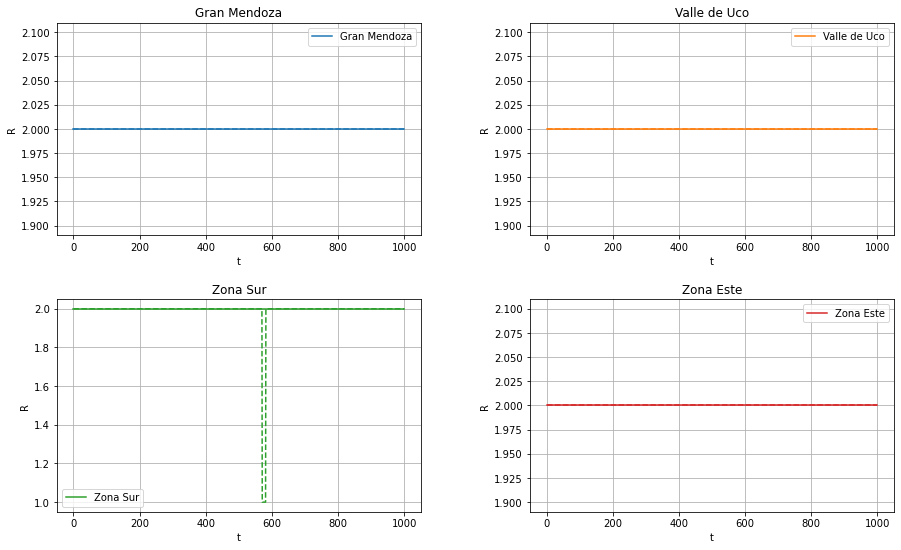

In [18]:
figura = plt.figure(figsize=(15.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,2,1)
ejes2 = figura.add_subplot(2,2,2)
ejes3 = figura.add_subplot(2,2,3)
ejes4 = figura.add_subplot(2,2,4)

ejes1.plot(tt,Rs_nos[0,:],color=colores[0],label=city_name[0])
ejes1.plot(tt,Rs[0,:],color=colores[0],linestyle='--')
ejes1.legend(loc='best')
ejes1.set_xlabel('t')
ejes1.grid()
ejes1.set_ylabel("R")
ejes1.set_title(city_name[0])

ejes2.plot(tt,Rs_nos[1,:],color=colores[1],label=city_name[1])
ejes2.plot(tt,Rs[1,:],color=colores[1],linestyle='--')
ejes2.legend(loc='best')
ejes2.set_xlabel('t')
ejes2.grid()
ejes2.set_ylabel("R")
ejes2.set_title(city_name[1])

ejes3.plot(tt,Rs_nos[2,:],color=colores[2],label=city_name[2])
ejes3.plot(tt,Rs[2,:],color=colores[2],linestyle='--')
#print(Rs[2,:])
ejes3.legend(loc='best')
ejes3.set_xlabel('t')
ejes3.grid()
ejes3.set_ylabel("R")
ejes3.set_title(city_name[2])

ejes4.plot(tt,Rs_nos[3,:],color=colores[3],label=city_name[3])
ejes4.plot(tt,Rs[3,:],color=colores[3],linestyle='--')
ejes4.legend(loc='best')
ejes4.set_xlabel('t')
ejes4.grid()
ejes4.set_ylabel("R")
ejes4.set_title(city_name[3])

# Results per area

Text(0.5, 1.0, '% ocupación Leves')

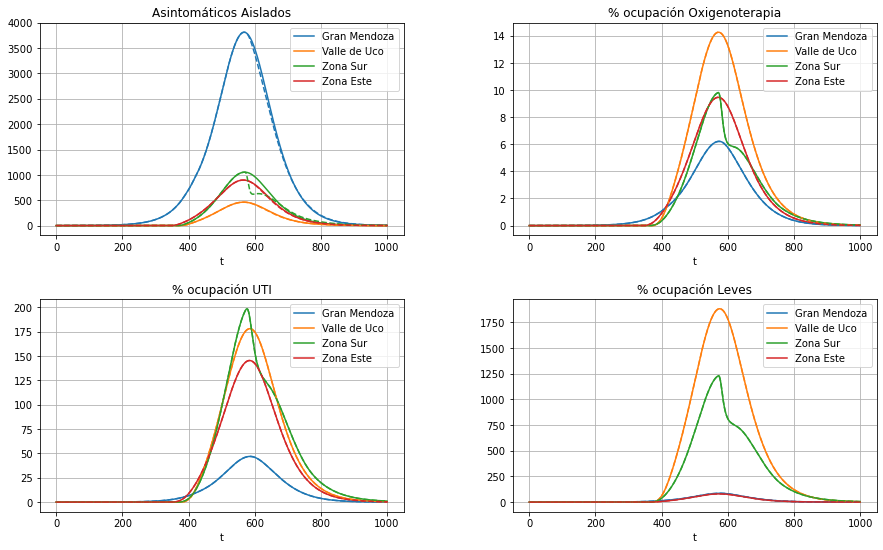

In [19]:
figura = plt.figure(figsize=(15.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,2,1)
ejes2 = figura.add_subplot(2,2,2)
ejes3 = figura.add_subplot(2,2,3)
ejes4 = figura.add_subplot(2,2,4)

for i in range(0,N_cities):
    ejes1.plot(tt,data_nos[i,:,4]*N0[i],color=colores[i],label=city_name[i])
for i in range(0,N_cities):
    ejes1.plot(tt,data[i,:,4]*N0[i],color=colores[i],linestyle='--')

ejes1.legend(loc='best')
ejes1.set_xlabel('t')
ejes1.grid()
ejes1.set_title("Isolated Asymptomatics")

for i in range(0,N_cities):
    ejes2.plot(tt,(100*data[i,:,6]*N0[i]/CAMAS_OXIGENOTERAPIA[i]),color=colores[i],label=city_name[i])
for i in range(0,N_cities):
    ejes2.plot(tt,(100*data[i,:,6]*N0[i]/CAMAS_OXIGENOTERAPIA[i]),color=colores[i],linestyle='--')
ejes2.legend(loc='best')
ejes2.set_xlabel('t')
ejes2.grid()
ejes2.set_title("% occupation Oxygen therapy")

for i in range(0,N_cities):
    ejes3.plot(tt,(100*data[i,:,7]*N0[i]/CAMAS_UTI[i]),color=colores[i],label=city_name[i])
for i in range(0,N_cities):
    ejes3.plot(tt,(100*data[i,:,7]*N0[i]/CAMAS_UTI[i]),color=colores[i],linestyle='--')

ejes3.legend(loc='best')
ejes3.set_xlabel('t')
ejes3.grid()
ejes3.set_title("% occupation ICU")

for i in range(0,N_cities):
    ejes4.plot(tt,(100*data[i,:,5]*N0[i]/CAMAS_LEVES[i]),color=colores[i],label=city_name[i])
for i in range(0,N_cities):
    ejes4.plot(tt,(100*data[i,:,5]*N0[i]/CAMAS_LEVES[i]),color=colores[i],linestyle='--')

ejes4.legend(loc='best')
ejes4.set_xlabel('t')
ejes4.grid()
ejes4.set_title("% occupation Mild")

# Deaths per zone

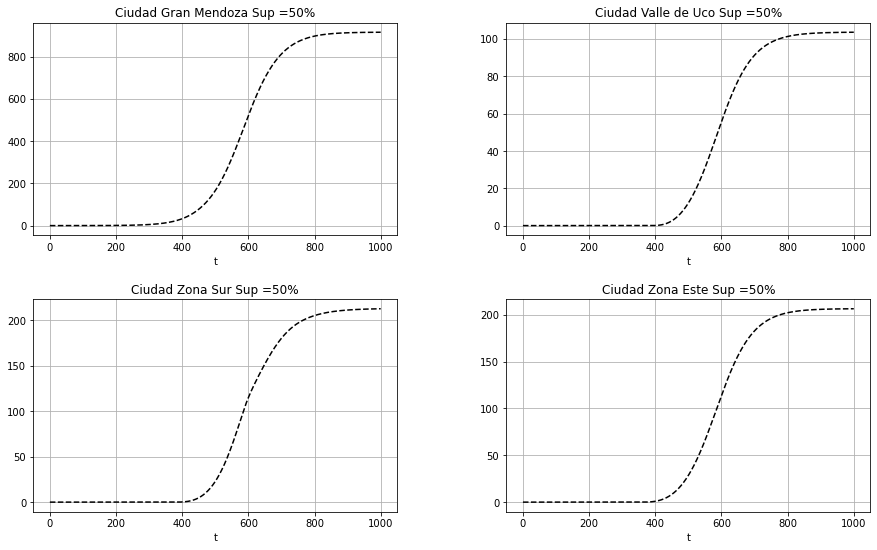

In [20]:
figura = plt.figure(figsize=(15.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,2,1)
ejes2 = figura.add_subplot(2,2,2)
ejes3 = figura.add_subplot(2,2,3)
ejes4 = figura.add_subplot(2,2,4)

ejes = [ejes1,ejes2,ejes3,ejes4]

for city in range(0,N_cities):
    eje = ejes[city]
    eje.set_title('Zone {0} Sup ={1:.0f}'.format(city_name[city],(1.0-suppression[city])*100) + '%' )
    #eje.legend(loc='best')
    eje.set_xlabel('t')
    #eje.set_yscale("log")
    eje.grid()
    eje.plot(tt,N0[city]*data[city,:,10],color="black",linestyle='--')

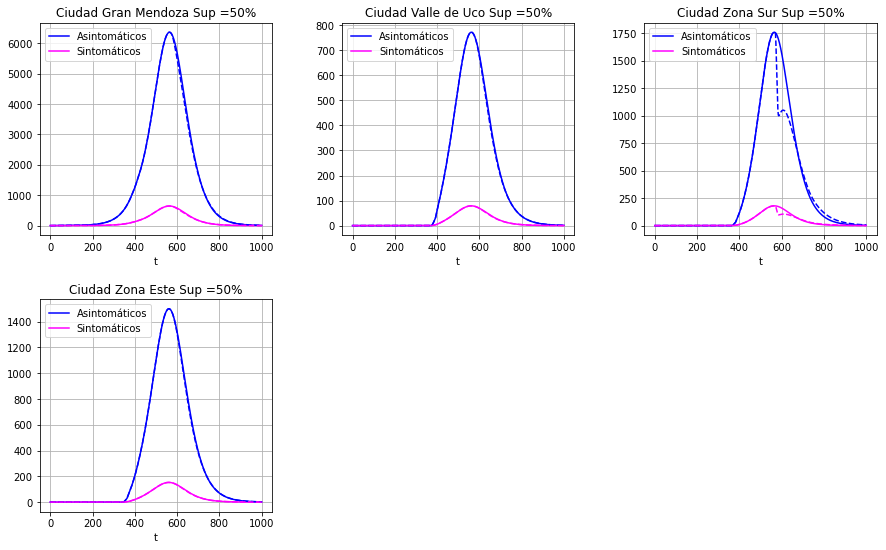

In [21]:
figura = plt.figure(figsize=(15.0,9.0))
figura.subplots_adjust(hspace=0.3, wspace=0.3)

ejes1 = figura.add_subplot(2,3,1)
ejes2 = figura.add_subplot(2,3,2)
ejes3 = figura.add_subplot(2,3,3)
ejes4 = figura.add_subplot(2,3,4)


ejes = [ejes1,ejes2,ejes3,ejes4]

for city in range(0,N_cities):
    eje = ejes[city]
    eje.set_title('Ciudad {0} Sup ={1:.0f}'.format(city_name[city],(1.0-suppression[city])*100) + '%' )
    eje.plot(tt,N0[city]*data_nos[city,:,2],color="blue",label="Asintomáticos")
    eje.plot(tt,N0[city]*data_nos[city,:,3],color="magenta",label="Sintomáticos")
    eje.legend(loc='best')
    eje.set_xlabel('t')
    #eje.set_yscale("log")
    eje.grid()

for city in range(0,N_cities):
    eje = ejes[city]
    eje.plot(tt,N0[city]*data[city,:,2],color="blue",linestyle='--')
    eje.plot(tt,N0[city]*data[city,:,3],color="magenta",linestyle='--')

# Save all data to excel

In [22]:
import pandas as pd

In [23]:
header = np.array(['day',
                   'R_0',
                   'Susceptible',
                   'Exposed',
                   'Asymptomatic',
                   'Symptomatic',
                   'Isolated Asymptomatic',
                   'Mild',
                   'Oxygen Therapy',
                   'ICU',
                   'Recovered from asymptomatic',
                   'Recovered from symptomatic',
                   'Dead'] )

parametros = []
header2 = np.array(['Parameter','Value'])
parametros.append(['R_0',R_0])
parametros.append(['f_A',f_A])
parametros.append(['D_inf',D_inf])
parametros.append(['D_inc',D_inc])
parametros.append(['D_rec',D_rec])
parametros.append(['D_recA',D_recA])
parametros.append(['D_lag',D_lag])
parametros.append(['D_recUTI',D_recUTI])
parametros.append(['D_A',D_A])
parametros.append(['p_A',p_A])
parametros.append(['p_S',p_S])
parametros.append(['p_UTI',p_UTI])
parametros.append(['p_F',p_F])
parametros.append(['p_AI',p_AI])
parametros.append(['[J[0,1]',J[0,1]])
parametros.append(['[J[0,2]',J[0,2]]) 
parametros.append(['[J[0,3]',J[0,3]])

params = pd.DataFrame(parametros,columns=header2)

dfs = []

for city in range(0,N_cities):
    dfs.append(pd.DataFrame(np.column_stack((tt,Rs[city,:],data[city,:,:])), columns = header))

with pd.ExcelWriter('with_suppression.xlsx') as writer:  
    for city in range(0,N_cities):
        dfs[city].to_excel(writer, sheet_name=city_name[city])
    params.to_excel(writer,sheet_name='Parámetros')    
    
dfs = []

for city in range(0,N_cities):
    dfs.append(pd.DataFrame(np.column_stack((tt,Rs_nos[city,:],data_nos[city,:,:])), columns = header))
    
with pd.ExcelWriter('sin.xlsx') as writer:  
    for city in range(0,N_cities):
        dfs[city].to_excel(writer, sheet_name=city_name[city])
    params.to_excel(writer,sheet_name='Parámetros')